# INSTALLAZIONE

In [ ]:
!pip install selenium #Keep also if working from local
!apt-get update #Comment this row if working from local
!apt install chromium-chromedriver #Comment this row if working from local (but the Chrome Driver should be manually installed)
!cp /usr/lib/chromium-browser/chromedriver /usr/bin #Comment this row if working from local
!pip install azure-storage-blob==2.1.0
!apt-get install unixodbc-dev
!pip install pyodbc

In [ ]:
%%sh
curl https://packages.microsoft.com/keys/microsoft.asc | apt-key add -
curl https://packages.microsoft.com/config/ubuntu/16.04/prod.list > /etc/apt/sources.list.d/mssql-release.list
sudo apt-get update
sudo ACCEPT_EULA=Y apt-get -q -y install msodbcsql17

In [ ]:
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
from selenium.webdriver import DesiredCapabilities
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import json
import pprint
import pyodbc
import time
import numpy as np
import os
from azure.storage.blob import BlockBlobService
from azure.storage.blob import ContentSettings
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import datetime
import pytz
import warnings
warnings.filterwarnings("ignore")

Functions

In [ ]:
def upload_file_to_Azure(path,filename):

  block_blob_service = BlockBlobService(account_name='bets', account_key='xxx')
  container_name = 'bets-datasets-bet'

  try:
      block_blob_service.create_blob_from_path(container_name,filename,path,content_settings=ContentSettings(content_type='application/CSV'))
      print(f'{filename} have been successfully imported into the Azure container {container_name}')  
  except Exception as e:
      print(e)
      pass

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#     

def create_id_match(c,conn,t1,t2,descr_match,dm):

  id_team_1 = ""
  id_team_2 = ""
  id_match = ""
  
  try:
   c.execute("select id_team from dbo.DIM_Teams where team like trim(upper(?))",'%'+ t1 + '%')
   id_team_1 = c.fetchone()
   if id_team_1 is None:
     raise Exception('Unable to decode team1:',t1) 
   else:
     print('id_team_1 is:',id_team_1[0])
  except Exception as e1:
    print(e1)

  try:
   c.execute("select id_team from dbo.DIM_Teams where team like trim(upper(?))",'%'+ t2 + '%')  
   id_team_2 = c.fetchone()
   if id_team_2 is None:
     raise Exception('Unable to decode team2:',t2) 
   else:
     print('id_team_2 is:',id_team_2[0])
  except Exception as e2:
    print(e2)
    
  id_match = str(id_team_1[0]).zfill(6) + str(id_team_2[0]).zfill(6) + date_match 
  
  try:
   c.execute("INSERT INTO DIM_Match (id_match, match, id_team_1, id_team_2, date_match) VALUES (?,?,?,?,?)",id_match,descr_match,id_team_1[0],id_team_2[0],date_match) 
   conn.commit()
  except Exception as e3:
    print(e3)

  return id_match


Constants

In [ ]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
 
wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
wd45 = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
wd35 = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
wd25 = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
wd15 = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
wd05 = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
wd.set_window_size(1920,1080)
wd05.set_window_size(1920,1080)
wd15.set_window_size(1920,1080)
wd25.set_window_size(1920,1080)
wd35.set_window_size(1920,1080)
wd45.set_window_size(1920,1080)
 
#set local timezone and test result
local_tz = pytz.timezone('Europe/Rome')
print(datetime.now(local_tz))

#db Azure
server = 'betsinsights.database.windows.net'
database = 'BETS' 
username = 'xxx' 
password = 'xxx' 
cnxn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# SCRAPER


Generate the identifier for this match 

In [ ]:
team_1 = 'SquadraCasa'
team_2 = 'SquadraTrasferta'
descr_match = 'SquadraCasa-SquadraTrasferta'
date_match = 'Data'

In [ ]:
new_id_match = ""

try:
 cursor.execute("SELECT id_match from dbo.DIM_Match m inner join dbo.DIM_Teams t1 on m.id_team_1 = t1.id_team and t1.team = ? inner join dbo.DIM_Teams t2 on m.id_team_2 = t2.id_team and t2.team = ? where date_match = ?",(team_1,team_2,date_match))
 id_match = cursor.fetchone() 
 if id_match is None:
  print('id_match has to be created')
  new_id_match = create_id_match(cursor,cnxn,team_1,team_2,descr_match,date_match)
  print('New id_match is: ',new_id_match)
 else:
  print('id_match already exists for this match:',id_match[0])
except Exception as e:
  print(e)

Start the scraping of the match

In [ ]:
link="LINK"
linku05 = "LINK05"
linku15 = "LINK15"
linku25 = "LINK25"
linku35 = "LINK35"
linku45 = "LINK45"
match = "SquadraCasa-SquadraTrasferta_Data"
gol = 0 #Gol avvenuti fino all'istante in cui inizi a far partire lo scraper (se sei in prematch metti 0)
righe=2000
#########################
minute = 'prematch'
c = 0
rows = righe
num = 0
num_fine = 0
k = 0
f = 0
ID=[]
quota1_p=[]
quotax_p=[]
quota2_p=[]
under05_p=[]
over05_p=[]
under15_p=[]
over15_p=[]
under25_p=[]
over25_p=[]
under35_p=[]
over35_p=[]
under45_p=[]
over45_p=[]
quota1_b=[]
quotax_b=[]
quota2_b=[]
under05_b=[]
over05_b=[]
under15_b=[]
over15_b=[]
under25_b=[]
over25_b=[]
under35_b=[]
over35_b=[]
under45_b=[]
over45_b=[]
minuto=[]
score=[]
goal = []
amount1x2=[]
amount05=[]
amount15=[]
amount25=[]
amount35=[]
amount45=[]
timestamp=[]
lavoro=[]
while minute!='Finito' and num < rows:
  num += 1
  wd.get(link)
  if gol < 1 :
    wd05.get(linku05)
  if gol < 2 :
    wd15.get(linku15)
  if gol < 3 :
    wd25.get(linku25)
  if gol < 4 :
    wd35.get(linku35)
  if gol < 5 :
    wd45.get(linku45)
  if gol > 4 :
    time.sleep(5)
  quote_p = wd.find_elements_by_css_selector("td.last-back-cell  .bet-button-price")
  quote_b = wd.find_elements_by_css_selector("td.bet-buttons.lay-cell.first-lay-cell > button > div > span.bet-button-price")
  eur1x2 = wd.find_elements_by_css_selector("span.total-matched") 
  score_live = wd.find_elements_by_css_selector("span.score")
  minuto_live = wd.find_elements_by_css_selector("bf-sports-header > div > div > div > ng-include p span")
  if gol < 1 :
    quote05_p = wd05.find_elements_by_css_selector("td.last-back-cell  .bet-button-price")
    quote05_b = wd05.find_elements_by_css_selector("td.bet-buttons.lay-cell.first-lay-cell > button > div > span.bet-button-price")
    eur05 = wd05.find_elements_by_css_selector("span.total-matched")
  if gol < 2 :
    quote15_p = wd15.find_elements_by_css_selector("td.last-back-cell  .bet-button-price")
    quote15_b = wd15.find_elements_by_css_selector("td.bet-buttons.lay-cell.first-lay-cell > button > div > span.bet-button-price")
    eur15 = wd15.find_elements_by_css_selector("span.total-matched")
  if gol < 3 :
    quote25_p = wd25.find_elements_by_css_selector("td.last-back-cell  .bet-button-price") 
    quote25_b = wd25.find_elements_by_css_selector("td.bet-buttons.lay-cell.first-lay-cell > button > div > span.bet-button-price")
    eur25 = wd25.find_elements_by_css_selector("span.total-matched")
  if gol < 4 :
    quote35_p = wd35.find_elements_by_css_selector("td.last-back-cell  .bet-button-price")
    quote35_b = wd35.find_elements_by_css_selector("td.bet-buttons.lay-cell.first-lay-cell > button > div > span.bet-button-price")
    eur35 = wd35.find_elements_by_css_selector("span.total-matched")
  if gol < 5 :
    quote45_p = wd45.find_elements_by_css_selector("td.last-back-cell  .bet-button-price")
    quote45_b = wd45.find_elements_by_css_selector("td.bet-buttons.lay-cell.first-lay-cell > button > div > span.bet-button-price")
    eur45 = wd45.find_elements_by_css_selector("span.total-matched")
  try:
    if k==0 and int(minuto_live[0].text.replace("""'""",""))>0:
      k=1
  except:
    pass
  timestamp.append(datetime.now(local_tz))
  ID.append(num)
#1
  try:
    if len(quote_p)>0 and len(quote_p[0].text)>0:
      q1_p = float(quote_p[0].text)
    else:
      q1_p= None 
  except:
    q1_p= None
  quota1_p.append(q1_p)
  try:
    if len(quote_b)>0 and len(quote_b[0].text)>0:
      q1_b = float(quote_b[0].text)
    else:
      q1_b= None
  except:
    q1_b= None
  quota1_b.append(q1_b)
#x
  try:
    if len(quote_p)>0 and len(quote_p[2].text)>0:
      qx_p = float(quote_p[2].text)
    else:
      qx_p= None
  except:
    qx_p= None
  quotax_p.append(qx_p)
  try:
    if len(quote_b)>0 and len(quote_b[2].text)>0:
      qx_b = float(quote_b[2].text)
    else:
      qx_b= None
  except:
    qx_b= None
  quotax_b.append(qx_b)
#2
  try:
    if len(quote_p)>0 and len(quote_p[1].text)>0:
      q2_p = float(quote_p[1].text)
    else:
      q2_p= None
  except:
    q2_p= None
  quota2_p.append(q2_p)
  try:
    if len(quote_b)>0 and len(quote_b[1].text)>0:
      q2_b = float(quote_b[1].text)
    else:
      q2_b= None
  except:
    q2_b= None
  quota2_b.append(q2_b)
#UNDER05
  try:
    if gol < 1 and len(quote05_p)>0 and len(quote05_p[0].text)>0 :
      qu05_p = float(quote05_p[0].text)
    else:
      qu05_p= None
  except:
    qu05_p= None
  under05_p.append(qu05_p)
  try:
    if gol < 1 and len(quote05_b)>0 and len(quote05_b[0].text)>0:
      qu05_b = float(quote05_b[0].text)
    else:
      qu05_b= None
  except:
    qu05_b= None
  under05_b.append(qu05_b)
#OVER05
  try:
    if gol < 1 and len(quote05_p)>0 and len(quote05_p[1].text)>0:
      qo05_p = float(quote05_p[1].text)
    else:
      qo05_p= None
  except:
    qo05_p= None
  over05_p.append(qo05_p)
  try:
    if gol < 1 and len(quote05_b)>0 and len(quote05_b[1].text)>0:
      qo05_b = float(quote05_b[1].text)
    else:
      qo05_b= None
  except:
    qo05_b= None
  over05_b.append(qo05_b)
#UNDER15
  try:
    if gol < 2 and len(quote15_p)>0 and len(quote15_p[0].text)>0:
      qu15_p = float(quote15_p[0].text)
    else:
      qu15_p= None
  except:
    qu15_p= None
  under15_p.append(qu15_p)
  try:
    if gol < 2 and len(quote15_b)>0 and len(quote15_b[0].text)>0:
      qu15_b = float(quote15_b[0].text)
    else:
      qu15_b= None
  except:
    qu15_b= None
  under15_b.append(qu15_b)
#OVER15
  try:
    if gol < 2 and len(quote15_p)>0 and len(quote15_p[1].text)>0:
      qo15_p = float(quote15_p[1].text)
    else:
      qo15_p= None
  except:
    qo15_p= None
  over15_p.append(qo15_p)
  try:
    if gol < 2 and len(quote15_b)>0 and len(quote15_b[1].text)>0:
      qo15_b = float(quote15_b[1].text)
    else:
      qo15_b= None
  except:
    qo15_b= None
  over15_b.append(qo15_b)
#UNDER25
  try:
    if gol < 3 and len(quote25_p)>0 and len(quote25_p[0].text)>0:
      qu25_p = float(quote25_p[0].text)
    else:
      qu25_p= None
  except:
    qu25_p= None
  under25_p.append(qu25_p)
  try:
    if gol < 3 and len(quote25_b)>0 and len(quote25_b[0].text)>0:
      qu25_b = float(quote25_b[0].text)
    else:
      qu25_b= None
  except:
    qu25_b= None
  under25_b.append(qu25_b)
#OVER25
  try:
    if gol < 3 and len(quote25_p)>0 and len(quote25_p[1].text)>0:
      qo25_p = float(quote25_p[1].text)
    else:
      qo25_p= None
  except:
    qo25_p= None
  over25_p.append(qo25_p)
  try:
    if gol < 3 and len(quote25_b)>0 and len(quote25_b[1].text)>0:
      qo25_b = float(quote25_b[1].text)
    else:
      qo25_b= None
  except:
    qo25_b= None
  over25_b.append(qo25_b)
#UNDER35
  try:
    if gol < 4 and len(quote35_p)>0 and len(quote35_p[0].text)>0:
      qu35_p = float(quote35_p[0].text)
    else:
      qu35_p= None
  except:
    qu35_p= None
  under35_p.append(qu35_p)
  try:
    if gol < 4 and len(quote35_b)>0 and len(quote35_b[0].text)>0:
      qu35_b = float(quote35_b[0].text)
    else:
      qu35_b= None
  except:
    qu35_b= None
  under35_b.append(qu35_b)
#OVER35
  try:
    if gol < 4 and len(quote35_p)>0 and len(quote35_p[1].text)>0:
      qo35_p = float(quote35_p[1].text)
    else:
      qo35_p= None
  except:
    qo35_p= None
  over35_p.append(qo35_p)
  try:
    if gol < 4 and len(quote35_b)>0 and len(quote35_b[1].text)>0:
      qo35_b = float(quote35_b[1].text)
    else:
      qo35_b= None
  except:
    qo35_b= None
  over35_b.append(qo35_b)
#UNDER45
  try:
    if gol < 5 and len(quote45_p)>0 and len(quote45_p[0].text)>0:
      qu45_p = float(quote45_p[0].text)
    else:
      qu45_p= None
  except:
    qu45_p= None
  under45_p.append(qu45_p)
  try:
    if gol < 5 and len(quote45_b)>0 and len(quote45_b[0].text)>0:
      qu45_b = float(quote45_b[0].text)
    else:
      qu45_b= None
  except:
    qu45_b= None
  under45_b.append(qu45_b)
#OVER45
  try:
    if gol < 5 and len(quote45_p)>0 and len(quote45_p[1].text)>0:
      qo45_p = float(quote45_p[1].text)
    else:
      qo45_p= None
  except:
    qo45_p= None
  over45_p.append(qo45_p)
  try:
    if gol < 5 and len(quote45_b)>0 and len(quote45_b[1].text)>0:
      qo45_b = float(quote45_b[1].text)
    else:
      qo45_b= None
  except:
    qo45_b= None
  over45_b.append(qo45_b)
#MINUTO
  try:
    if len(minuto_live)>0:
      minute=minuto_live[0].text
    elif k==0 and len(minuto_live)==0 :
      minute='prematch'
    elif k==1 :
      minute='updating'
  except:
    minute = None
  minuto.append(minute)
#SCORE
  try:
    if len(minuto_live)>0:
      risultato=score_live[0].text
    elif k==0 and len(minuto_live) == 0:
      risultato = 'prematch'  
    elif k==1:
      risultato='updating'
  except:
    risultato = None
  score.append(risultato)
#GOL
  try:
    gol = int(risultato.split('-')[0]) + int(risultato.split('-')[1])
  except:
    pass
#ROWS
  try:
    if minute != 'prematch' and minute != 'updating' and minute != None:
      if c==0 and (89 - int(minute.replace("""'""",""))) < 0:
        if risultato != 'prematch' and risultato != 'updating' and risultato != None:
          if gol < 3 :
            rows = num + 50
          else :
            rows = num + 100
          c = 1
          num_fine = rows
  except:
    pass
  if c == 1 :
    num_fine -= 1
    print (num_fine)
#AMOUNT 1X2
  try:
    if len(eur1x2)>0:
      euro1x2=eur1x2[0].text
    else: 
      euro1x2 = None
  except:
    euro1x2 = None
  amount1x2.append(euro1x2)
#AMOUNT u05
  try:
    if gol < 1 and len(eur05)>0:
      euro05=eur05[0].text
    else: 
      euro05 = None
  except:
    euro05 = None
  amount05.append(euro05)
#AMOUNT u15
  try:
    if gol < 2 and len(eur15)>0:
      euro15=eur15[0].text
    else: 
      euro15 = None
  except:
    euro15 = None  
  amount15.append(euro15)
#AMOUNT u25
  try:
    if gol < 3 and len(eur25)>0:
      euro25=eur25[0].text
    else: 
      euro25 = None
  except:
    euro25 = None  
  amount25.append(euro25)
#AMOUNT u35
  try:
    if gol < 4 and len(eur35)>0:
      euro35=eur35[0].text
    else: 
      euro35 = None
  except:
    euro35 = None    
  amount35.append(euro35)   
#AMOUNT u45
  try:
    if gol < 5 and len(eur45)>0:
      euro45=eur45[0].text
    else: 
      euro45 = None
  except:
    euro45 = None 
  amount45.append(euro45)

  print("ID:",ID[-1])
  print("Minuto:",minuto[-1])
  print("Risultato:",score[-1])
  print("Gol totali:",gol)
  print("1 buy:",quota1_p[-1])
  print("x buy:",quotax_p[-1])
  print("2 buy:",quota2_p[-1])
  print("u05 buy:",under05_p[-1])
  print("o05 buy:",over05_p[-1])
  print("u15 buy:",under15_p[-1])
  print("o15 buy:",over15_p[-1])
  print("u25 buy:",under25_p[-1])
  print("o25 buy:",over25_p[-1])
  print("u35 buy:",under35_p[-1])
  print("o35 buy:",over35_p[-1])
  print("u45 buy:",under45_p[-1])
  print("o45 buy:",over45_p[-1])
  print("amount 1x2:",amount1x2[-1])
  print("amount05:",amount05[-1])
  print("amount15:",amount15[-1])
  print("amount25:",amount25[-1])
  print("amount35:",amount35[-1])
  print("amount45:",amount45[-1])
  print("timestamp:",timestamp[-1])
  print("--------------------------------")
     

for i in range(len(amount1x2)):
  try:
    if amount1x2[i] != None :
      amount1x2[i] = int(amount1x2[i].replace("EUR ","").replace(",",""))
  except:
    pass
for i in range(len(amount05)):
  try:
    if amount1x2[i] != None :
      amount05[i] = int(amount05[i].replace("EUR ","").replace(",","")) 
  except:
    pass
for i in range(len(amount15)):
  try:
    if amount1x2[i] != None :
      amount15[i] = int(amount15[i].replace("EUR ","").replace(",",""))
  except:
    pass
for i in range(len(amount25)):
  try:
    if amount1x2[i] != None :
      amount25[i] = int(amount25[i].replace("EUR ","").replace(",",""))
  except:
    pass
for i in range(len(amount35)):
  try:
    if amount1x2[i] != None :
      amount35[i] = int(amount35[i].replace("EUR ","").replace(",",""))
  except:
    pass
for i in range(len(amount45)):
  try:
    if amount1x2[i] != None :
      amount45[i] = int(amount45[i].replace("EUR ","").replace(",",""))
  except:
    pass
for i in range(len(score)):
  try:
    if score[i] != None and score[i] != 'prematch' and score[i] != 'updating' :
      gol = int(score[i].split('-')[0]) + int(score[i].split('-')[1])
    else:
      gol = None
  except:
    gol = None
  goal.append(gol)
for i in range(len(goal)):
  if i != 0 and i != (len(goal)-1):
    if goal[i-1] != None and goal[i+1] != None and goal[i-1] == goal[i+1] :
      goal[i] = goal[i-1]  

for i in range(len(minuto)):
  try :
    if minuto[i] != 'prematch' and  minuto[i] != 'updating' and minuto[i] != 'Finito' and minuto[i] != None :
      minuto[i] = minuto[i].replace("""'""",'')
      if minuto[i] == 'Intervallo' and f == 0:
        f = 1
      if f == 1 and minuto[i] != 'Intervallo':
        minuto_int = int(minuto[i]) + 1
        minuto[i] = str(minuto_int)
      if f == 0 and int(minuto[i]) > 45:
        minuto[i] = '45'
  except:
    pass

lavoro.append({'ID': new_id_match,
            'score': score,
           'minuto': minuto,
           'goal' : goal,
         'quota1_p': quota1_p,
         'quotax_p': quotax_p,
         'quota2_p': quota2_p,
        'under05_p': under05_p,
         'over05_p': over05_p,
        'under15_p': under15_p,
         'over15_p': over15_p,
          'under25_p': under25_p,
           'over25_p': over25_p,
          'under35_p': under35_p,
           'over35_p': over35_p,
          'under45_p': under45_p,
           'over45_p': over45_p,
           'quota1_b': quota1_b,
           'quotax_b': quotax_b,
           'quota2_b': quota2_b,
           'under05_b': under05_b,
           'over05_b': over05_b,
          'under15_b': under15_b,
           'over15_b': over15_b,
          'under25_b': under25_b,
           'over25_b': over25_b,
          'under35_b': under35_b,
           'over35_b': over35_b,
          'under45_b': under45_b,
           'over45_b': over45_b,
           'amount1x2': amount1x2,
           'amount05': amount05,
           'amount15': amount15,
           'amount25': amount25,
           'amount35': amount35,
           'amount45': amount45,
        'timestamp': timestamp})

#create the Dataframe through pandas
dataset = pd.DataFrame(*lavoro)
dataset.set_index("ID")
dataset['l_1x2_p']=round((1/dataset['quota1_p']+1/dataset['quotax_p']+1/dataset['quota2_p'])*100,1)
dataset['l_1x2_b']=round((1/dataset['quota1_b']+1/dataset['quotax_b']+1/dataset['quota2_b'])*100,1)
try:
  dataset['l_u05_p']=round((1/dataset['under05_p']+1/dataset['over05_p'])*100,1)
  dataset['l_u05_b']=round((1/dataset['under05_b']+1/dataset['over05_b'])*100,1)
except:
  for i in range(len(under05_p)) :
    dataset['l_u05_p'] = None
    dataset['l_u05_b'] = None
try:
  dataset['l_u15_p']=round((1/dataset['under15_p']+1/dataset['over15_p'])*100,1)
  dataset['l_u15_b']=round((1/dataset['under15_b']+1/dataset['over15_b'])*100,1)
except:
  for i in range(len(under05_p)) :
    dataset['l_u15_p'] = None
    dataset['l_u15_b'] = None
try:
  dataset['l_u25_p']=round((1/dataset['under25_p']+1/dataset['over25_p'])*100,1)
  dataset['l_u25_b']=round((1/dataset['under25_b']+1/dataset['over25_b'])*100,1)
except:
  for i in range(len(under05_p)) :
    dataset['l_u25_p'] = None
    dataset['l_u25_b'] = None
try:
  dataset['l_u35_p']=round((1/dataset['under35_p']+1/dataset['over35_p'])*100,1)
  dataset['l_u35_b']=round((1/dataset['under35_b']+1/dataset['over35_b'])*100,1) 
except:
  for i in range(len(under05_p)) :
    dataset['l_u35_p'] = None
    dataset['l_u35_b'] = None
try:
  dataset['l_u45_p']=round((1/dataset['under45_p']+1/dataset['over45_p'])*100,1)
  dataset['l_u45_b']=round((1/dataset['under45_b']+1/dataset['over45_b'])*100,1)
except:
  for i in range(len(under05_p)) :
    dataset['l_u45_p'] = None
    dataset['l_u45_b'] = None

Data cleaning


1.   Removing the 'updating' world through the entire dataset and replace it with None


In [ ]:
column_list = list(dataset.columns)
for c in column_list:
  dataset[c] = dataset[c].replace('updating','')

Set the dataset into CSV file format

In [ ]:
try:
  dataset['ID'] = id_match[0]
  dataset
except:
  pass

In [ ]:
nome_file = (f'{match}.csv')
dataset.to_csv(f'/content/drive/My Drive/MATCH/{nome_file}',index=False)
path = (f'/content/drive/My Drive/MATCH/{nome_file}')

Upload the file to the Azure container 

In [ ]:
upload_file_to_Azure(path,nome_file)

# IMPORT MANUALE

In [ ]:
import os #SET WORKING DIRECTORY
os.chdir('/content/drive/My Drive/MATCH')

In [ ]:
dataset=pd.read_csv('Barcellona - Bayern Monaco_20200814.csv')

# GRAFICI

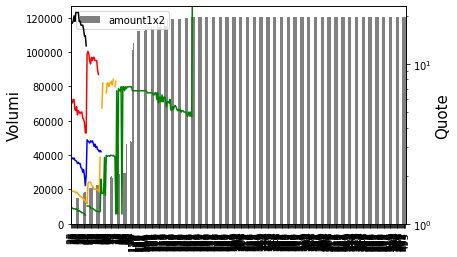

384


,amount1x2,under05_p,under15_p,under25_p,under35_p,under45_p,minuto,timestamp
493,120577,NaN,NaN,NaN,NaN,NaN,92',2020-08-25 13:49:59.254416+02:00
494,120577,NaN,NaN,NaN,NaN,NaN,91',2020-08-25 13:50:05.234679+02:00
495,120577,NaN,NaN,NaN,NaN,NaN,91',2020-08-25 13:50:11.331183+02:00


In [ ]:
df = pd.DataFrame(dataset, columns=["amount1x2","under05_p","under15_p","under25_p","under35_p","under45_p","minuto","timestamp"])
df = df[df["minuto"] != 'prematch']
df = df[df["minuto"] != 'Finito']
df = df[df["minuto"] != 'Intervallo']
#df = df[:-55]

ax = df[['amount1x2']].plot(kind='bar', use_index=True,color='grey')
ax2 = ax.twinx()
ax2.plot(df[['under05_p']].values, linestyle='-', linewidth=1.5,color='black')
ax2.plot(df[['under15_p']].values, linestyle='-', linewidth=1.5,color='red')
ax2.plot(df[['under25_p']].values, linestyle='-', linewidth=1.5,color='blue')
ax2.plot(df[['under35_p']].values, linestyle='-', linewidth=1.5,color='orange')
ax2.plot(df[['under45_p']].values, linestyle='-', linewidth=1.5,color='green')
ax2.set_yscale("log")

ax2.set_ylim(1, max(df.under05_p)+2)
ax.set_ylabel("Volumi", fontsize=15, color="black")
ax2.set_ylabel("Quote", fontsize=15, color="black")

plt.show()
print(len(df.amount1x2))
df.head(3)
df.tail(3)

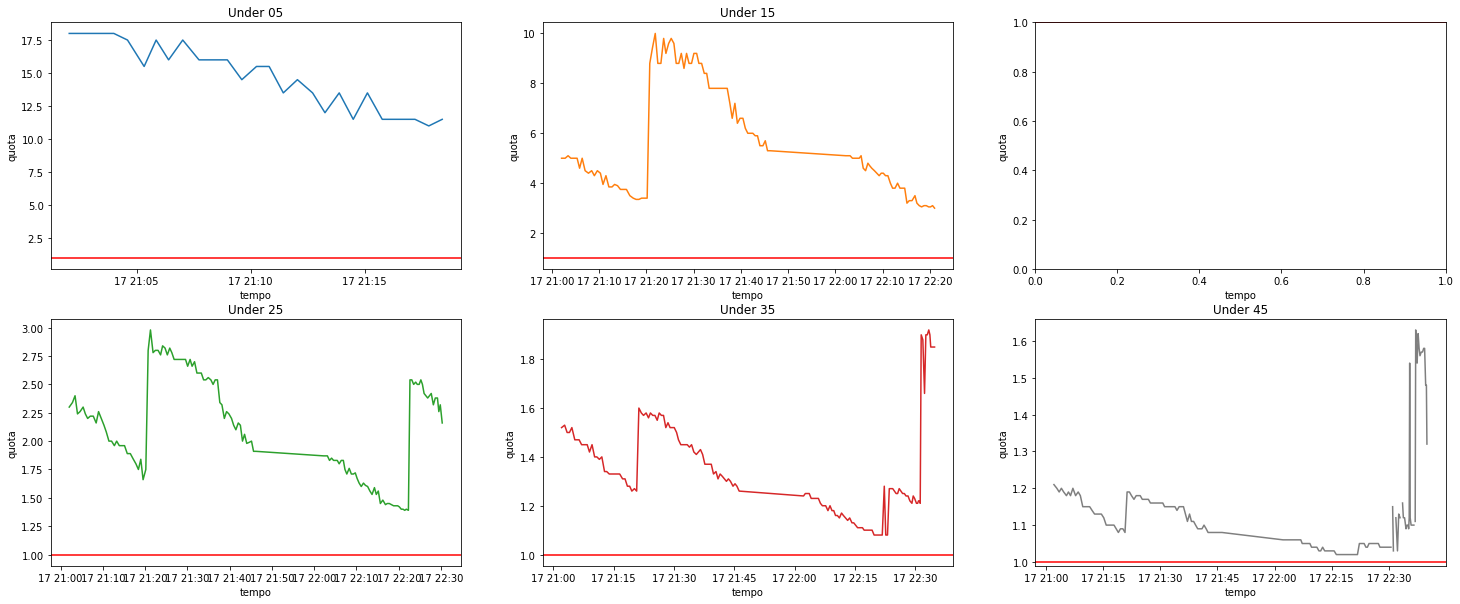

In [ ]:
fig, axs = plt.subplots(2, 3)
x=df.timestamp
y1=df.under05_p
y2=df.under15_p
y3=df.under25_p
y4=df.under35_p
y5=df.under45_p
axs[0, 0].plot(x, y1)
axs[0, 0].set_title('Under 05')
axs[0, 1].plot(x, y2, 'tab:orange')
axs[0, 1].set_title('Under 15')
axs[1, 0].plot(x, y3, 'tab:green')
axs[1, 0].set_title('Under 25')
axs[1, 1].plot(x, y4, 'tab:red')
axs[1, 1].set_title('Under 35')
axs[1, 2].plot(x, y5, 'tab:grey')
axs[1, 2].set_title('Under 45')
fig.set_size_inches(25, 10)

for ax in axs.flat:
    ax.set(xlabel='tempo', ylabel='quota')
    ax.axhline(y=1,color='r')

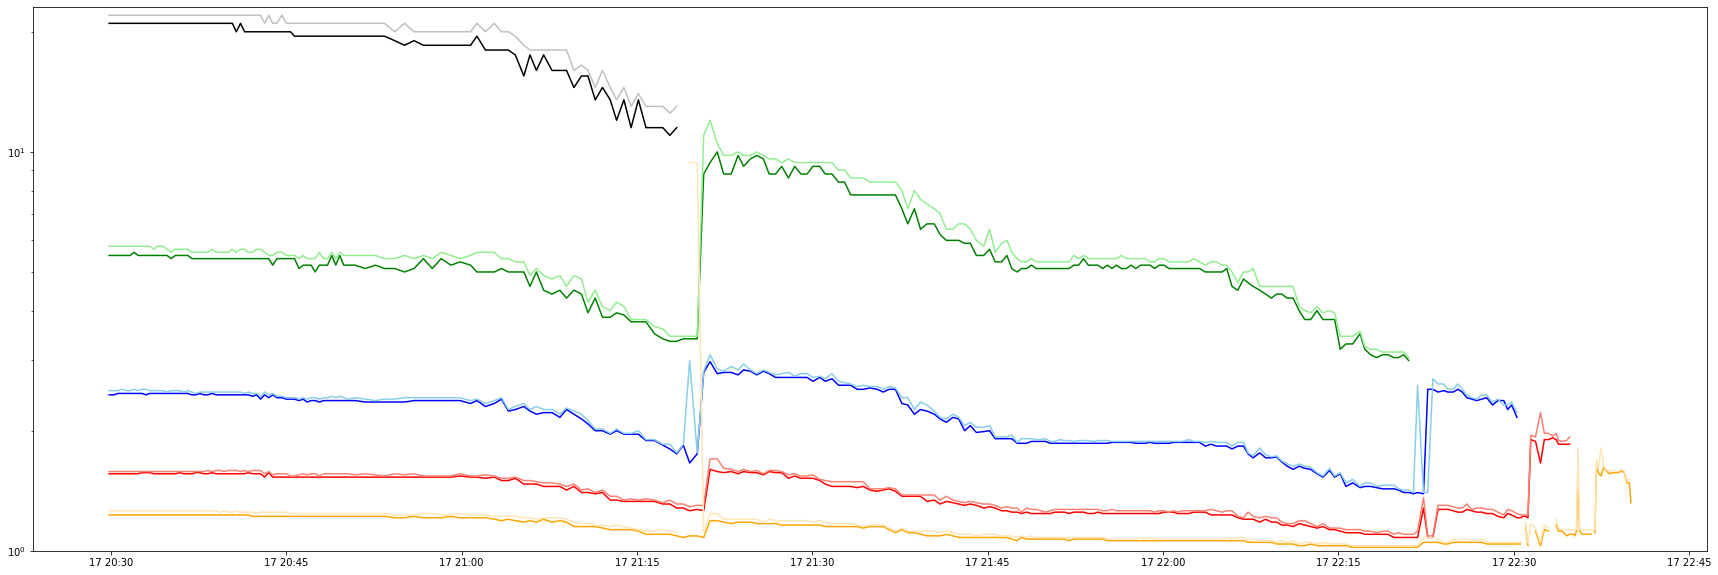

In [ ]:
#UNDER
plt.figure(figsize=(30,10))
plt.plot(dataset.timestamp,dataset.under05_p,color='black')
plt.plot(dataset.timestamp,dataset.under15_p,color='green')
plt.plot(dataset.timestamp,dataset.under25_p,color='blue')
plt.plot(dataset.timestamp,dataset.under35_p,color='red')
plt.plot(dataset.timestamp,dataset.under45_p,color='orange')
plt.plot(dataset.timestamp,dataset.under05_b,color='silver')
plt.plot(dataset.timestamp,dataset.under15_b,color='lightgreen')
plt.plot(dataset.timestamp,dataset.under25_b,color='skyblue')
plt.plot(dataset.timestamp,dataset.under35_b,color='salmon')
plt.plot(dataset.timestamp,dataset.under45_b,color='moccasin')
plt.ylim(1,)
plt.yscale('log')
plt.show()

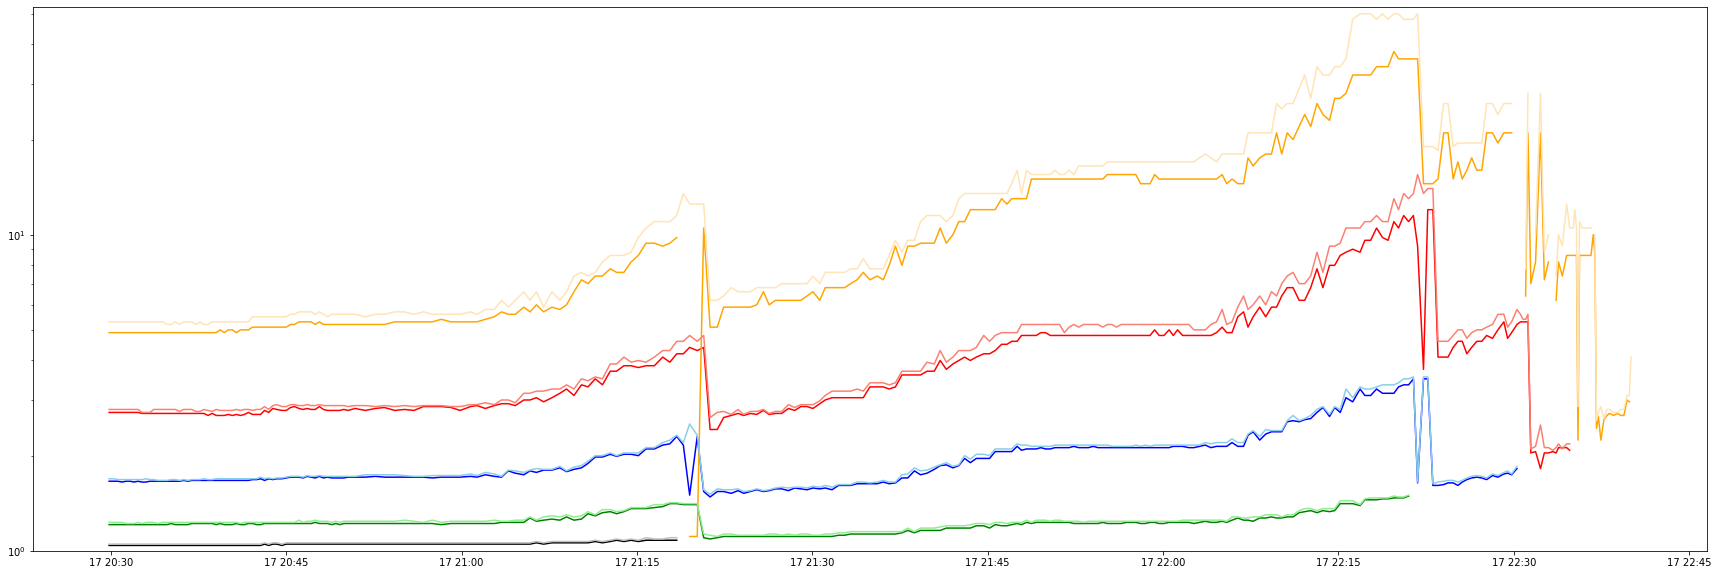

In [ ]:
#OVER
plt.figure(figsize=(30,10))
plt.plot(dataset.timestamp,dataset.over05_p,color='black')
plt.plot(dataset.timestamp,dataset.over15_p,color='green')
plt.plot(dataset.timestamp,dataset.over25_p,color='blue')
plt.plot(dataset.timestamp,dataset.over35_p,color='red')
plt.plot(dataset.timestamp,dataset.over45_p,color='orange')
plt.plot(dataset.timestamp,dataset.over05_b,color='silver')
plt.plot(dataset.timestamp,dataset.over15_b,color='lightgreen')
plt.plot(dataset.timestamp,dataset.over25_b,color='skyblue')
plt.plot(dataset.timestamp,dataset.over35_b,color='salmon')
plt.plot(dataset.timestamp,dataset.over45_b,color='moccasin')
plt.ylim(1,)
plt.yscale('log')
plt.show()

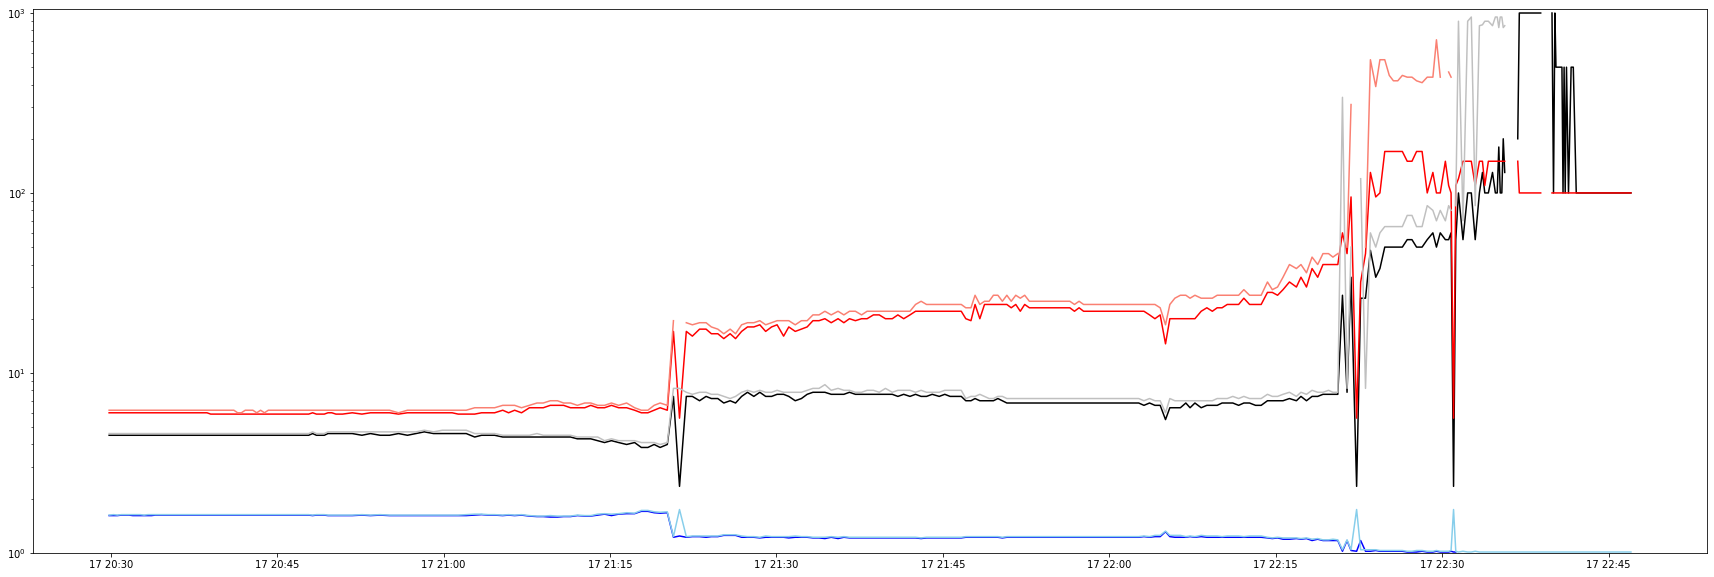

In [ ]:
#1X2
plt.figure(figsize=(30,10))
plt.plot(dataset.timestamp,dataset.quota1_p,color='blue')
plt.plot(dataset.timestamp,dataset.quotax_p,color='black')
plt.plot(dataset.timestamp,dataset.quota2_p,color='red')
plt.plot(dataset.timestamp,dataset.quota1_b,color='skyblue')
plt.plot(dataset.timestamp,dataset.quotax_b,color='silver')
plt.plot(dataset.timestamp,dataset.quota2_b,color='salmon')
plt.ylim(1,)
plt.yscale('log')
plt.show()

In [ ]:
dataset.dtypes

In [ ]:
#1X2
plt.figure(figsize=(30,10))
plt.plot(dataset.timestamp,dataset.quotax_p,color='blue')
dataset['quotax_p_mm']  = dataset.quotax_p.rolling(window=10).mean()
plt.plot(dataset.timestamp,dataset.quotax_p_mm,color='red')
plt.ylim(1,)
plt.yscale('log')
plt.show()

In [ ]:
#LAVAGNE
plt.figure(figsize=(30,10))
plt.plot(dataset.timestamp,dataset.l_1x2_p,color='blue')
plt.plot(dataset.timestamp,dataset.l_u05_p,color='black')
plt.plot(dataset.timestamp,dataset.l_u15_p,color='red')
plt.plot(dataset.timestamp,dataset.l_u25_p,color='green')
plt.plot(dataset.timestamp,dataset.l_u35_p,color='orange')
plt.plot(dataset.timestamp,dataset.l_u45_p,color='purple')
plt.ylim(100,105)
plt.yscale('log')
plt.show()

# APPEND

In [ ]:
#APPEND DUE DATASET
dataset0=pd.read_csv('Barcellona - Bayern Monaco_1_20200814.csv')
dataset1=pd.read_csv('Barcellona - Bayern Monaco_2_20200814.csv')
print(len(dataset0.timestamp))
print(len(dataset1.timestamp))
dataset2=dataset1.append(dataset0).sort_values(by=['timestamp'])
dataset2
print(len(dataset2.timestamp))
dataset2.to_csv('/content/drive/My Drive/MATCH/Barcellona - Bayern Monaco_20200814.csv',index=False)

500
600
1100


In [ ]:
#APPEND TRE DATASET
dataset0=pd.read_csv('Atalanta - PSG_20200812.csv')
dataset1=pd.read_csv('Atalanta-PSG_20200812v2.csv')
dataset2=pd.read_csv('Atalanta-PSG_20200812v1.csv')
dataset3=dataset1.append(dataset0).append(dataset2).sort_values(by=['timestamp'])
dataset3
dataset3.to_csv('/content/drive/My Drive/MATCH/Atalanta-PSG_20200812.csv',index=False)